In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt

## Red Neuronal RNN-LSTM-GRU con dataset de KAGGLE para series de tiempo
#### https://www.kaggle.com/datasets/ixhele/bitcoin-time-series
####  Contexto
#### Los datos representan series de tiempo históricas diarias para una moneda digital (BTC)
Rango de fecha de datos: 2018-05-11 al 2021-01-30

In [2]:
# Paso 1: Cargar el dataset
df = pd.read_csv('bitcoin_usd.csv', index_col='Unnamed: 0', parse_dates=True)
df.index.name = 'fecha'
df.reset_index(inplace=True)

In [3]:
# Convertir la columna 'fecha' en tipo datetime y ordenar el dataframe
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')

In [4]:
# Paso 2: Preparar los datos
data = df[['close_USD']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Crear un dataset de secuencias
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [6]:
SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [7]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
# Función para construir y entrenar modelos
def build_and_train_model(model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(16, activation='relu', input_shape=(SEQ_LENGTH, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(16, activation='relu', input_shape=(SEQ_LENGTH, 1)))
    elif model_type == 'GRU':
        model.add(GRU(16, activation='relu', input_shape=(SEQ_LENGTH, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = model.predict(X_test)
    return model, history, y_pred

In [9]:
# Entrenar y obtener predicciones para cada tipo de modelo
models = {}
histories = {}
predictions = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    model, history, y_pred = build_and_train_model(model_type, X_train, y_train, X_test, y_test)
    models[model_type] = model
    histories[model_type] = history
    predictions[model_type] = y_pred

C:\Users\deyvi.caicedo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [10]:
# Desnormalizar las predicciones y los datos de prueba
def inverse_transform_predictions(y_pred, y_test):
    y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 1)), y_test], axis=1))[:, 1]
    y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 1)), y_pred], axis=1))[:, 1]
    return y_test_inv, y_pred_inv

In [11]:
# Calcular métricas de evaluación
metrics = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    y_test_inv, y_pred_inv = inverse_transform_predictions(predictions[model_type], y_test)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    metrics[model_type] = (mse, rmse, mae)

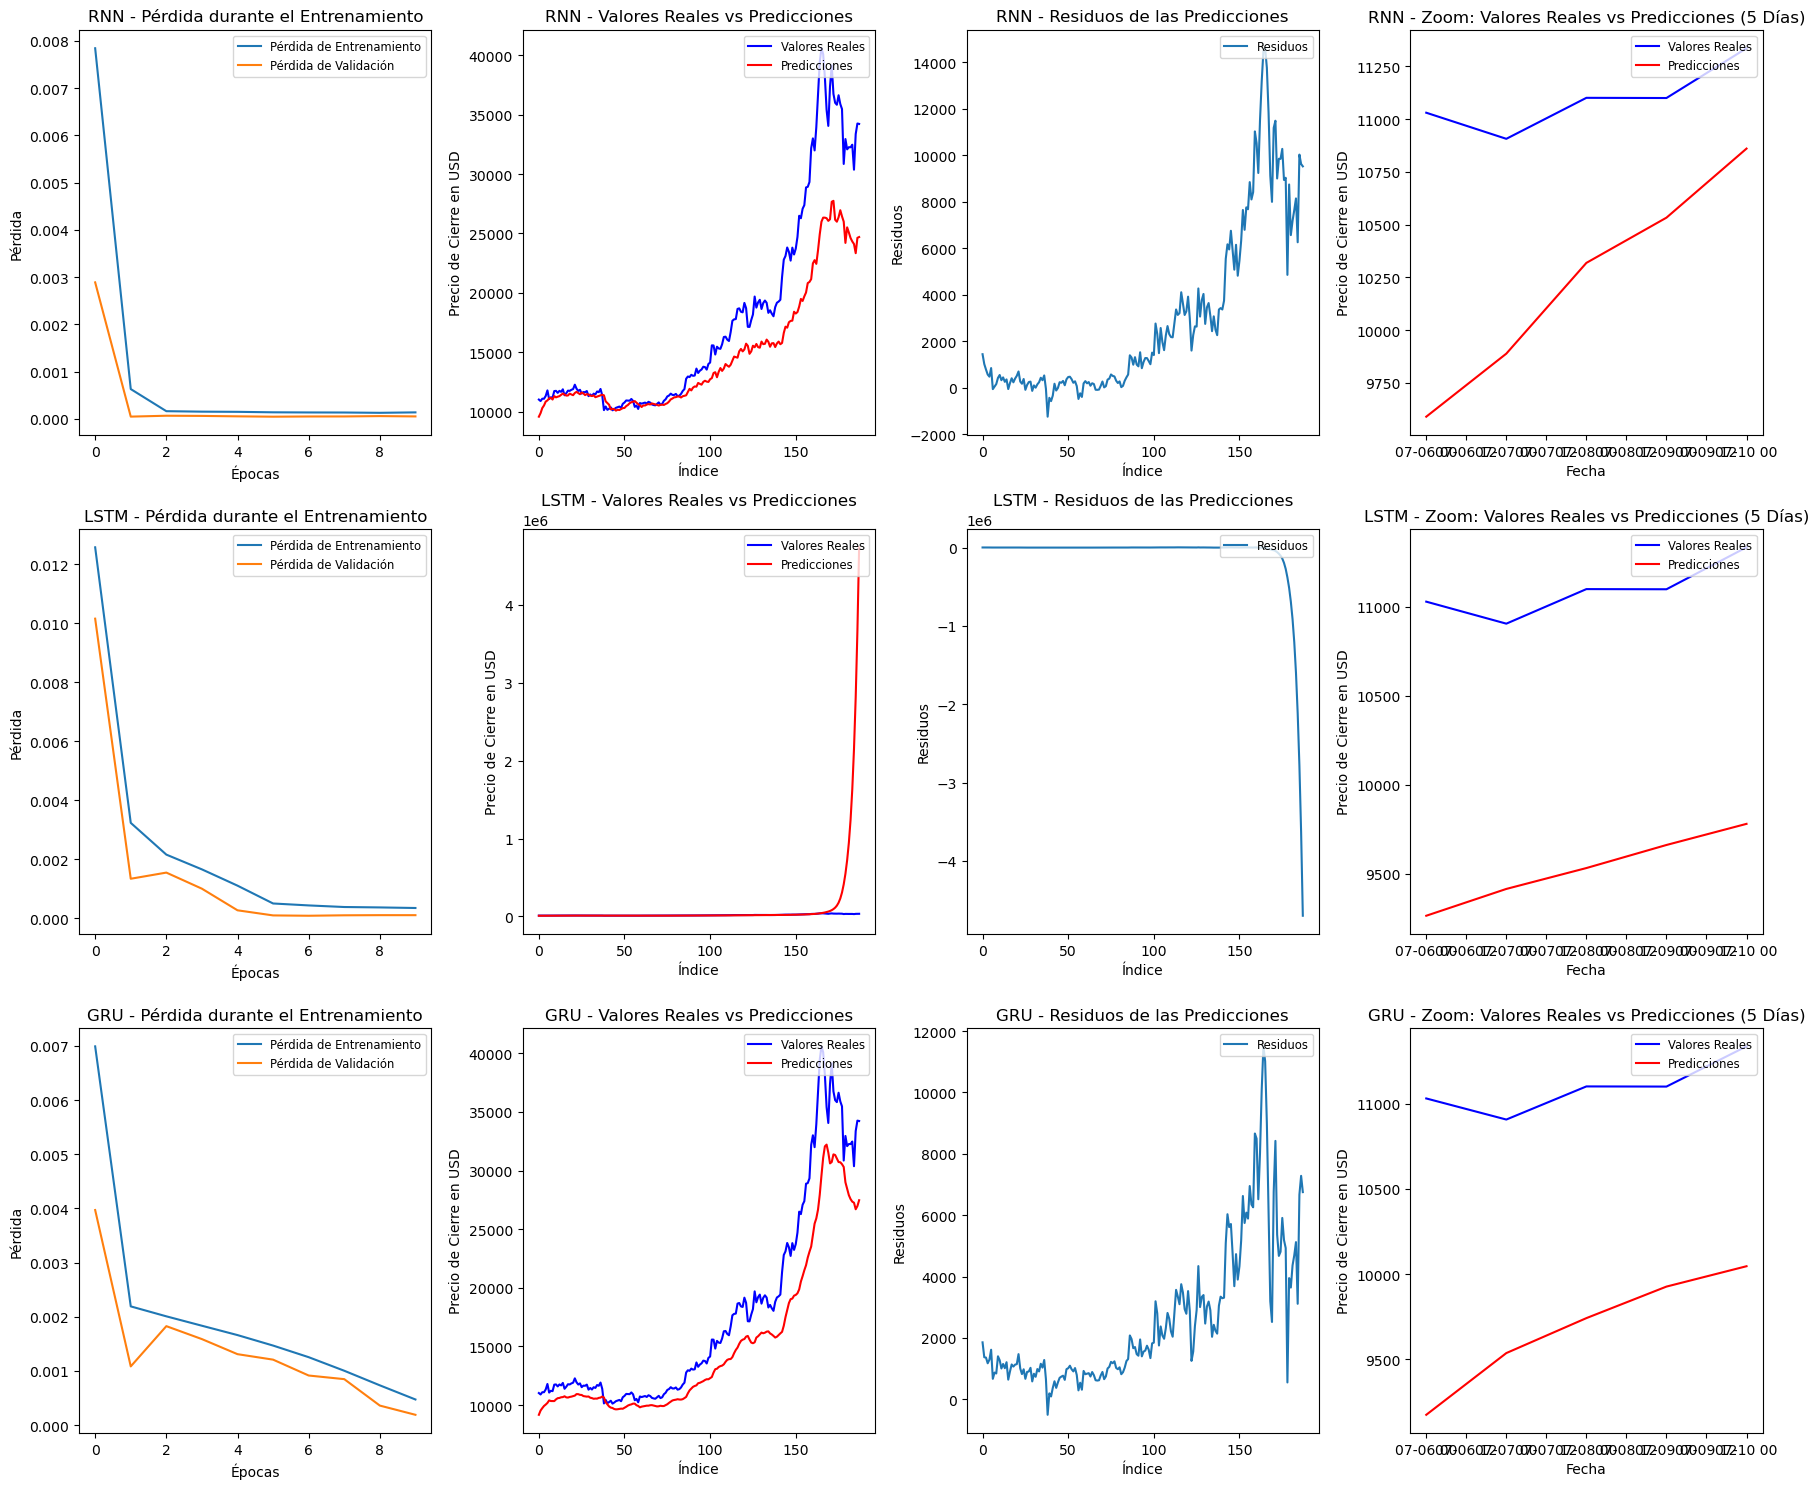

In [12]:
# Graficar resultados
plt.figure(figsize=(18, 15))

for i, model_type in enumerate(['RNN', 'LSTM', 'GRU'], 1):
    plt.subplot(3, 4, (i - 1) * 4 + 1)
    plt.plot(histories[model_type].history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(histories[model_type].history['val_loss'], label='Pérdida de Validación')
    plt.title(f'{model_type} - Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc='upper right', fontsize='small')

    plt.subplot(3, 4, (i - 1) * 4 + 2)
    y_test_inv, y_pred_inv = inverse_transform_predictions(predictions[model_type], y_test)
    plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores Reales', color='blue')
    plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones', color='red')
    plt.title(f'{model_type} - Valores Reales vs Predicciones')
    plt.xlabel('Índice')
    plt.ylabel('Precio de Cierre en USD')
    plt.legend(loc='upper right', fontsize='small')

    plt.subplot(3, 4, (i - 1) * 4 + 3)
    residuals = y_test_inv - y_pred_inv
    plt.plot(residuals, label='Residuos')
    plt.title(f'{model_type} - Residuos de las Predicciones')
    plt.xlabel('Índice')
    plt.ylabel('Residuos')
    plt.legend(loc='upper right', fontsize='small')

    # Gráfico de zoom: ventana de 5 días
    start_index = 0
    end_index = 5
    plt.subplot(3, 4, (i - 1) * 4 + 4)
    plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_test_inv[start_index:end_index], label='Valores Reales', color='blue')
    plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_pred_inv[start_index:end_index], label='Predicciones', color='red')
    plt.title(f'{model_type} - Zoom: Valores Reales vs Predicciones (5 Días)')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre en USD')
    plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

In [13]:
# Imprimir métricas
for model_type in ['RNN', 'LSTM', 'GRU']:
    mse, rmse, mae = metrics[model_type]
    print(f"{model_type} - Mean Squared Error (MSE): {mse}")
    print(f"{model_type} - Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model_type} - Mean Absolute Error (MAE): {mae}")
    print()


RNN - Mean Squared Error (MSE): 22032743.59616059
RNN - Root Mean Squared Error (RMSE): 4693.904941108266
RNN - Mean Absolute Error (MAE): 2994.405019709873

LSTM - Mean Squared Error (MSE): 284055508471.1697
LSTM - Root Mean Squared Error (RMSE): 532968.5811294786
LSTM - Mean Absolute Error (MAE): 104904.14385205235

GRU - Mean Squared Error (MSE): 11958469.131738076
GRU - Root Mean Squared Error (RMSE): 3458.10195508144
GRU - Mean Absolute Error (MAE): 2593.8986542994735



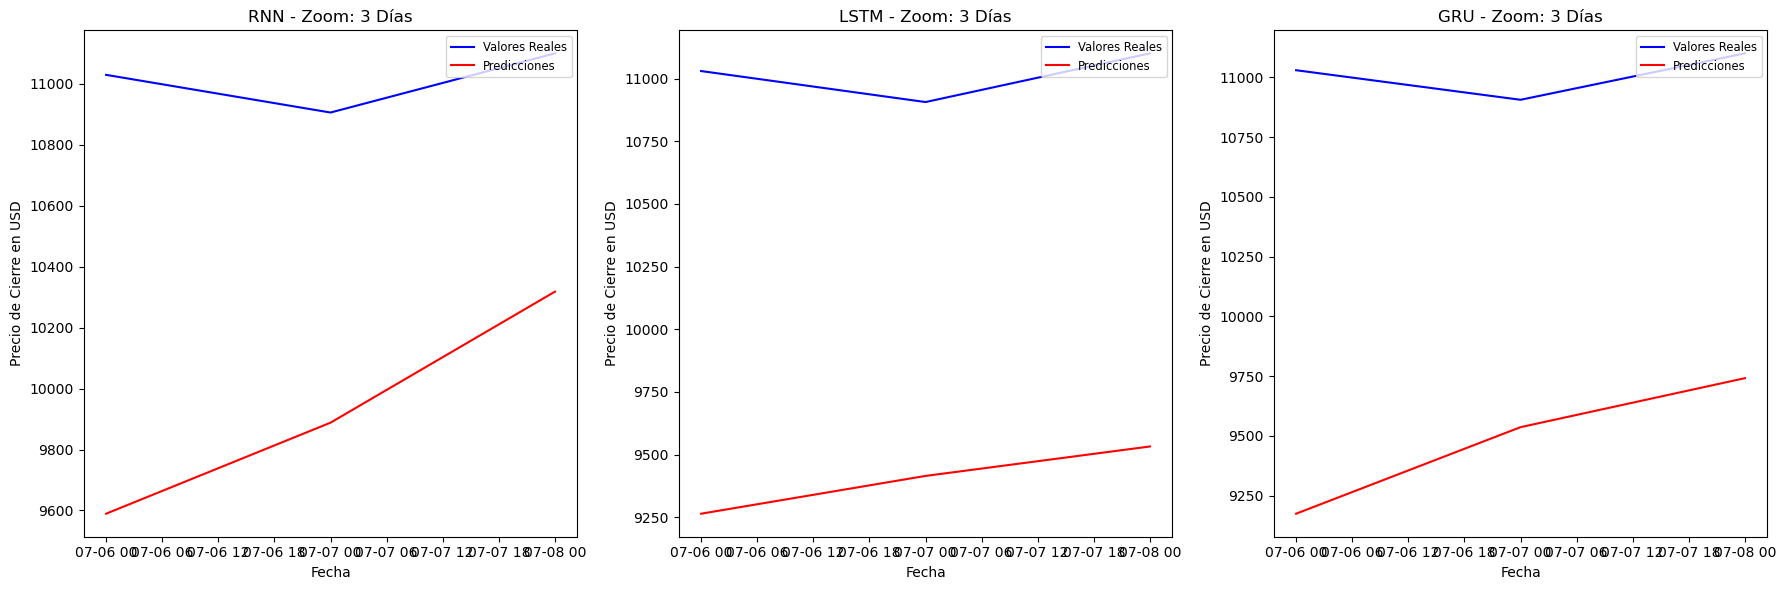

In [15]:
# Gráfica final comparativa para los tres modelos
plt.figure(figsize=(18, 6))
start_index = 0
end_index = 3

for i, model_type in enumerate(['RNN', 'LSTM', 'GRU'], 1):
    plt.subplot(1, 3, i)
    y_test_inv, y_pred_inv = inverse_transform_predictions(predictions[model_type], y_test)
    plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_test_inv[start_index:end_index], label='Valores Reales', color='blue')
    plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_pred_inv[start_index:end_index], label='Predicciones', color='red')
    plt.title(f'{model_type} - Zoom: 3 Días')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre en USD')
    plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()